# Modelling calcium trace behavior 

##References
[1] Chen, T. W., Wardill, T. J., Sun, Y., Pulver, S. R., Renninger, S. L., Baohan, A., ... & Looger, L. L. (2013). Ultrasensitive fluorescent proteins for imaging neuronal activity. Nature, 499(7458), 295-300.

##Task
- Build a model that describes the connection between spiking data and calcium traces. 
- Survey and use existing programs that convert calcium signals to spiking data as for example done by Jason Kerr. 

##Background
Considere Figure 3 from [1]:

![title](img/figure3.png)

As can be seen in a) and b) calcium traces do show distinct curves for certain underlying spiking events. The dynamic interplay between a spike train and the calcium trace likeliy to be produces by it will be modeled here.

We will proceed in a step wise fasion starting with a very crude model that is not biophysiologically accurate and then slowly work our way but to produce a more realistic model. 

#Let's get started 
- start with a single neuron
- aproximate calcium trace by a simple alpha function
- put function together in piecewise fasion for now with no additive or multiplicative behavior

This is just a starting point and entirely biophysiologically inaccurate! 

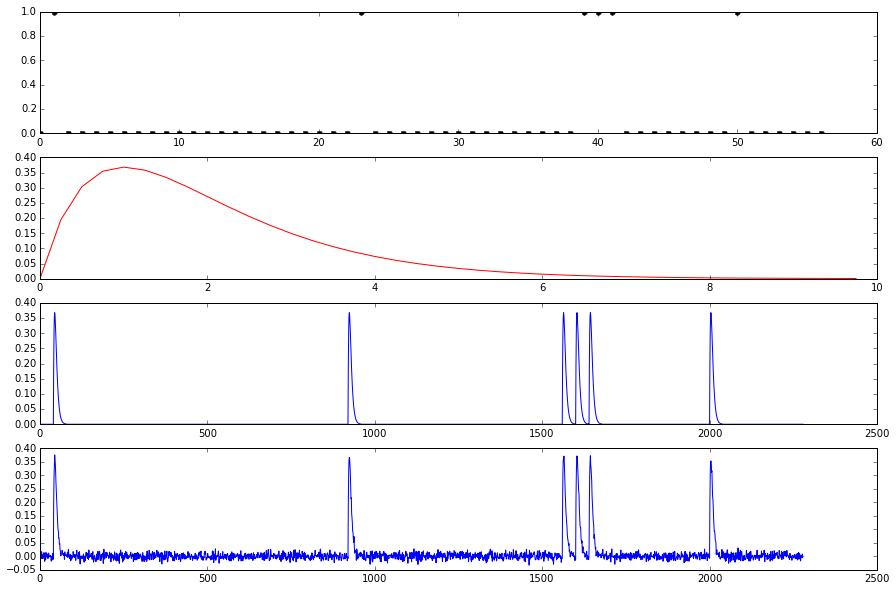

In [1]:
# An implementation of a calcium trace model
# 
# Code by J.V. Schulze - April 2016

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# FUNCTIONS #################################################

# Alpha function to approcimate the shape of a calcium trace
def alpha_func(t):
    a = 1
    b = 1
    return a * t * np.exp(- b*t)

def produceCalciumTrace(spiketrain, temp):
    # given a spike train produce the likely calcium trace
    values = []
    for slot in spiketrain:
        if slot == 0:
            # in case nothing occures add string of zeros
            for value in temp:
                values.append(0)   
        elif slot == 1:
            # in case a spike occured add template piece
            for value in temp:
                values.append(value)
        else:
            values.append(0)
    return values

def addnoise(pure):
    # given a pure signal add some random normal distributed noise
    noise = np.random.normal(0, 0.01, len(pure))
    signal = pure + noise
    return signal

# A spike train is just a list of 0s and 1s
# 1s stand for an action potential occuring
# each slot repersents 1msec
spiketrain = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
              ,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]


# Template has the form of an alpha function
# the length of the template is given by the time interval t
t = np.arange(0.0, 10.0, 0.25)
template = alpha_func(t)

x = produceCalciumTrace(spiketrain, template)

# Add noise to make the data more realistic
# In real 2-photon microscopy data we have about 10% noise
noisy_x = addnoise(x)


# PLOTTING ##################################################
plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(spiketrain, '.k', ms=10)

plt.subplot(412)
plt.plot(t, alpha_func(t), 'r')

plt.subplot(413)
plt.plot(x)

plt.subplot(414)
plt.plot(noisy_x)

plt.show()

#Adding and Multiplicating the Template
Previously the template was just inserted whenever a spike occured. Now let's add/mutiply it instead such that close by spikes show 'dynamics' closer to what we observe in Figure 3.

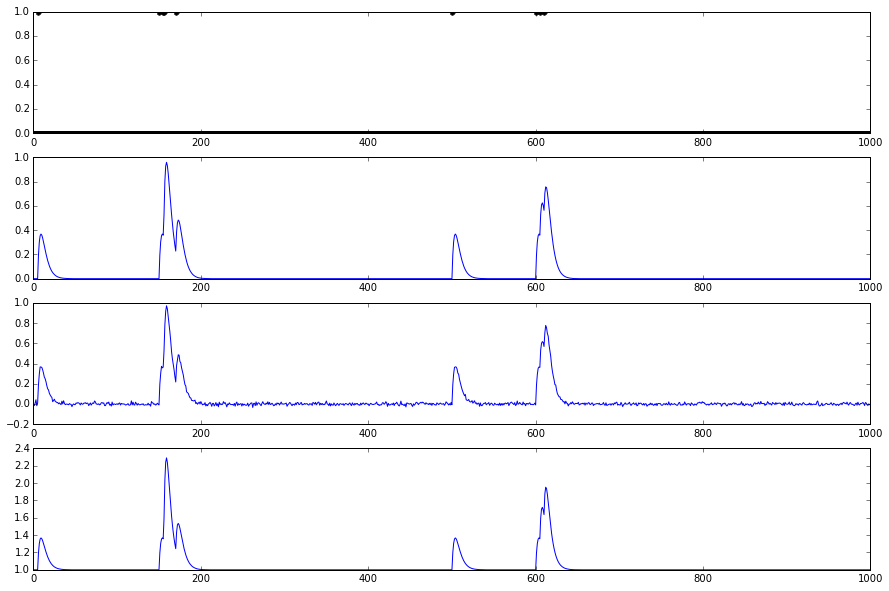

In [69]:
def produceCalciumTraceAdditive(spiketrain, temp):
    # given a spike train, produce the likely calcium trace
    values = np.zeros_like(spiketrain, dtype=np.float) # <-- Omitting type float produced problem:
    # You might think that adding values afterwards would let you add floating points numbers 
    # but they are getting converted to int! 
    for i, slot in enumerate(spiketrain):
        if slot == 0:
            # in case nothing occures add zero
            values[i] += 0.0   
        elif slot == 1:
            # in case a spike occured add template piece
            for j, value in enumerate(temp):
                if i + j < len(values):
                    new_value = float(values[i+j]) + float(value)
                    #print("After calculation ", new_value)
                    values.put((i+j),new_value)
                    #print("Atfter putting in ", values[i+j])
    return values

def produceCalciumTraceMultiplicative(spiketrain, temp):
    # given a spike train produce the likely calcium trace
    values = np.ones_like(spiketrain, dtype=np.float)
    beta = 1
    #print(values)
    for i, slot in enumerate(spiketrain):
        if slot == 0:
            # in case nothing occures add string of zeros
            values[i] += 0   
        elif slot == 1:
            # in case a spike occured add template piece
            for j, value in enumerate(temp):
                #print(j)
                if i + j < len(values):
                    values[i+j] = values[i+j] * (value +1) * beta
                #print(values)
        else:
            values.append(0)
    return values


# Template has the form of an alpha function
# the length of the template is given by the time interval t
t = np.arange(0.0, 10.0, 0.25)
template = alpha_func(t)
#template = [2,3,4,5]

spiketrain = np.zeros(1000)
spiketrain[5] = 1
spiketrain[150] = 1
spiketrain[155] = 1
spiketrain[156] = 1
spiketrain[170] = 1
spiketrain[500] = 1
spiketrain[600] = 1
spiketrain[605] = 1
spiketrain[610] = 1

x = produceCalciumTraceAdditive(spiketrain, template)
x2 = produceCalciumTraceMultiplicative(spiketrain, template)

# Add noise to make the data more realistic
# In real 2-photon microscopy data we have about 10% noise
noisy_x = addnoise(x)


# PLOTTING ##################################################
plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(spiketrain, '.k', ms=10)

plt.subplot(412)
plt.plot(x)

plt.subplot(413)
plt.plot(noisy_x)

plt.subplot(414)
plt.plot(x2)

plt.show()

# More than one neuron
Let's start thinking about adding more than one neuron.

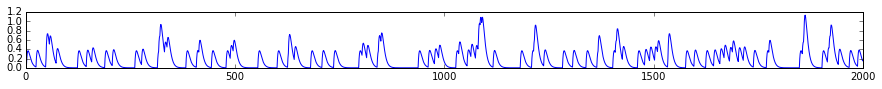

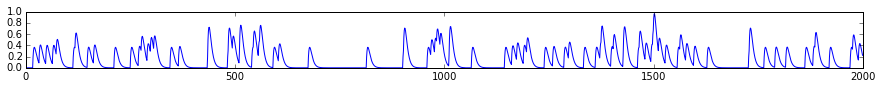

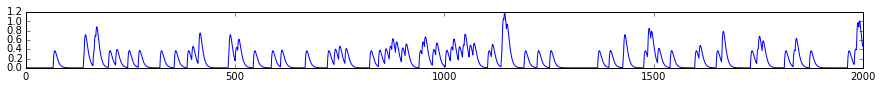

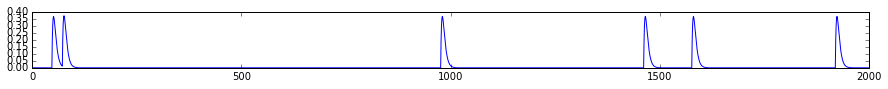

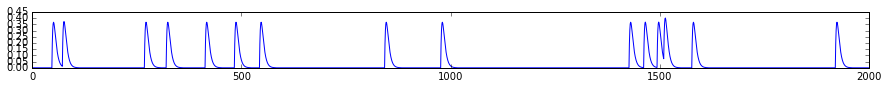

In [126]:
import random

def randBinList(alpha, r):
    seq = []
    for i in range(r):
        number = random.randint(0,alpha)
        if number == 1:
            seq.append(1)
        else:
            seq.append(0)
    return seq

class Neuron():
    def __init__(self, time):
        self.active = False #neuron is inactive
        self.activation = dict.fromkeys(range(time), 0) #neuron produces no action potentials
        self.input_neurons = [] #no neurons are connected
        self.clamped = False
        self.random = False
        self.threshold = 1
        
    def run(self, time):
        self.active = True
        self.activation = dict.fromkeys(range(time), 0)
        spiketrain = self.__calculateactivation(time)
        self.active = False
        return spiketrain
        
    def connect(self, neuron):
        self.input_neurons.append(neuron)
    
    def __calculateactivation(self, time):
        spiketrain = []
        
        # If the neuron is clamped it's _always_ fireing 
        # TODO: think refactory perior 
        if self.clamped:
            for step in range(time):
                self.activation[step] = 1
        
        # Some random firing 
        # TODO: not realistic 
        elif self.random:
                for i in range(time):
                    number = random.randint(0,20)
                    if number == 1:
                        self.activation[i] = 1
                    else:
                        self.activation[i] = 0
        
        else:
            for step in range(time):
                sum_inputs = 0
                for neuron in self.input_neurons:
                    #print("Step ", step, "Value ", neuron.activation[step])
                    sum_inputs += neuron.activation[step] 
                    #print("Sum ", sum_inputs)
                if sum_inputs > self.threshold:
                    self.activation[step] = 1
                else:
                    self.activation[step] = 0   
        spiketrain = list(self.activation.values())
        return spiketrain

class NeuronGroup():
    def __init__(self, neurons=[]):
        self.neurons = neurons    
    
    def record(self, time):
        spiketrains = []
        data = []
        for neuron in self.neurons:
            # run neuron; Order matters!
            # get its spiketrain
            spiketrain = neuron.run(time)
            spiketrains.append(spiketrain)
            # calculate calcium trace
            datum = produceCalciumTraceAdditive(spiketrain, template)
            data.append(datum)
            # display all traces
            plt.figure(figsize=(15, 1))
            plt.plot(datum)
            plt.show()
                
           
n1 = Neuron(2000)
n2 = Neuron(2000)
n3 = Neuron(2000)
n4 = Neuron(2000)
n5 = Neuron(2000)

# How neuons are connected
n1.connect(n2) # n2 -> n1
n1.connect(n3) # n3 -> n1
n3.connect(n4) # n4 -> n3
n5.connect(n2)
n5.connect(n3)
n5.connect(n4)

# Three randomly activated neurons as input layer
n2.random = True
n3.random = True
n4.random = True
input_layer = NeuronGroup([n2,n3,n4])
input_layer.record(2000)

# Two output neurons
output_layer = NeuronGroup([n1,n5])
output_layer.record(2000)

# One neuron that receives input from the input layer neurons
#spiketrain1 = n1.run(2000)
#data = produceCalciumTraceAdditive(spiketrain1, template)
#noisy_data = addnoise(data)
#plt.figure(figsize=(15, 10))
#plt.plot(noisy_data)

# Random networks
The above small network is hand coded. Let's think about how to produce randomly connected networks.


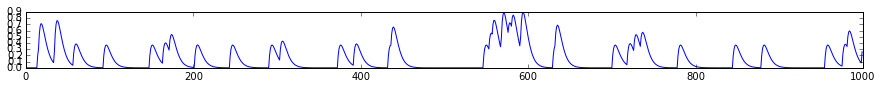

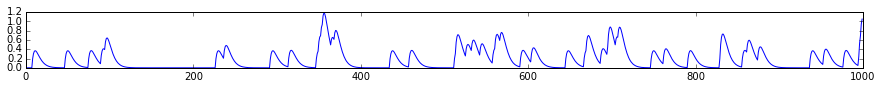

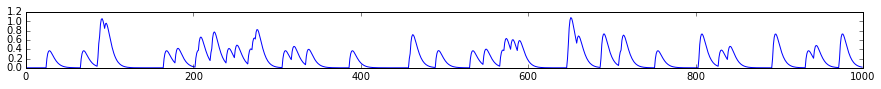

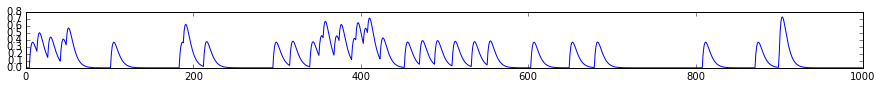

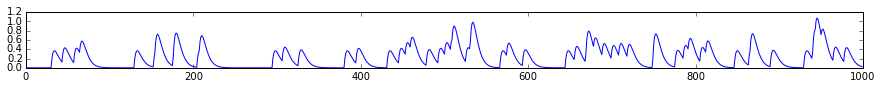

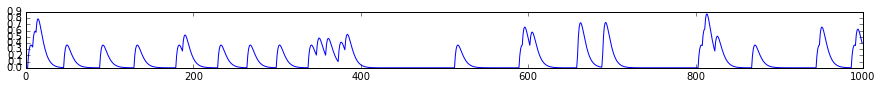

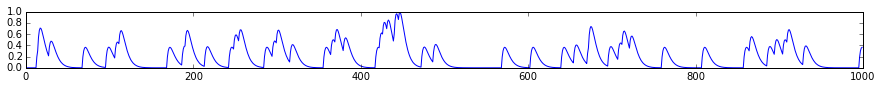

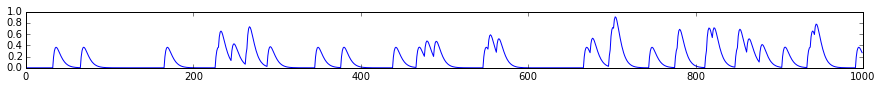

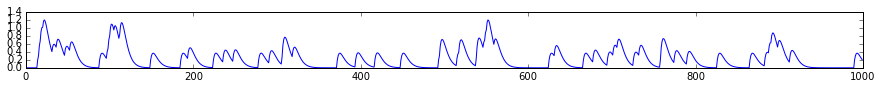

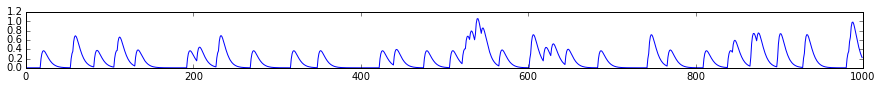

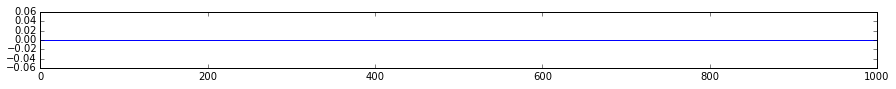

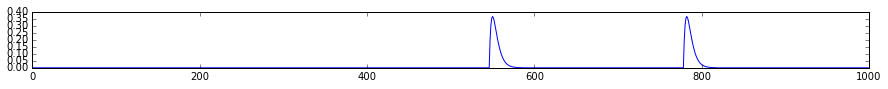

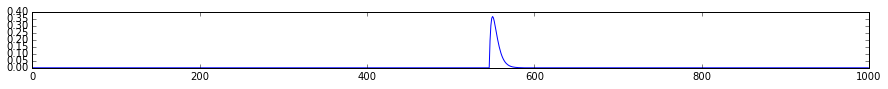

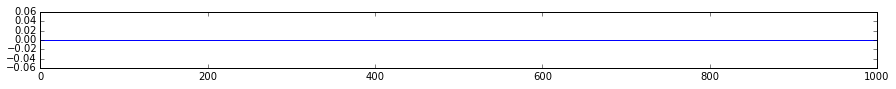

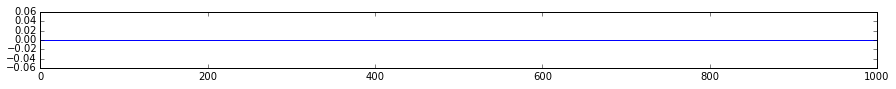

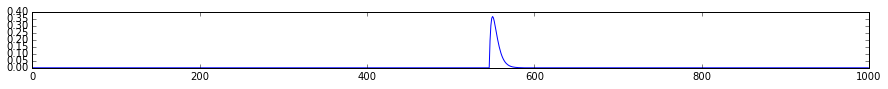

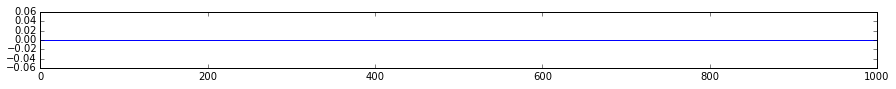

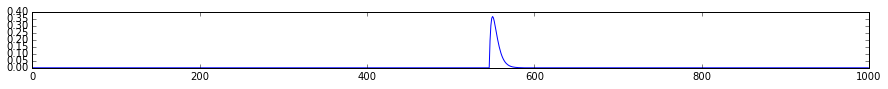

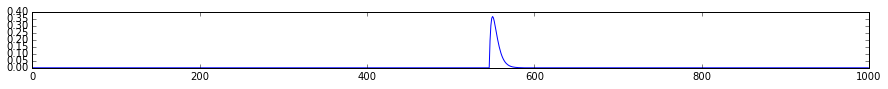

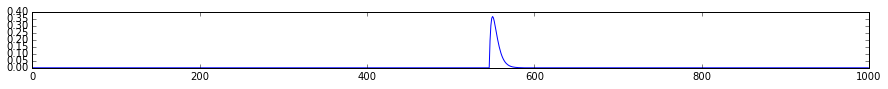

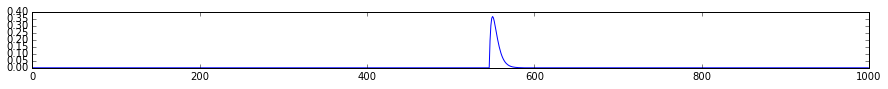

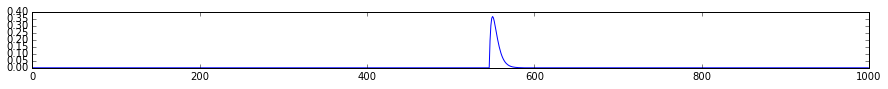

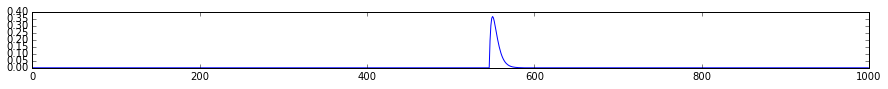

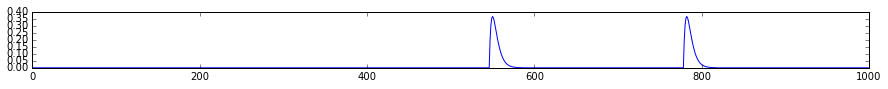

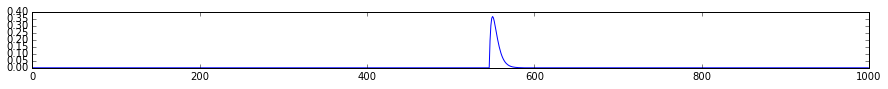

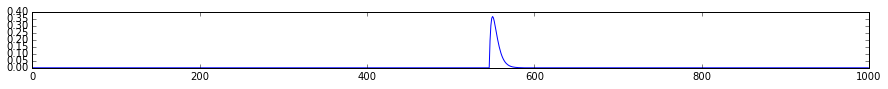

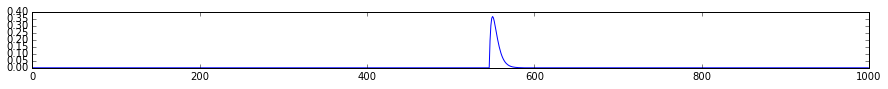

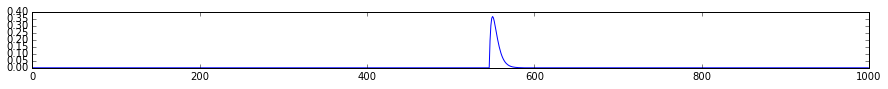

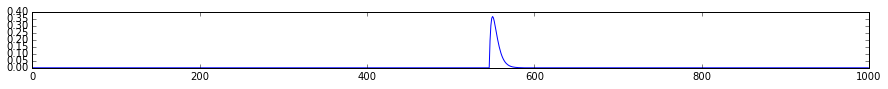

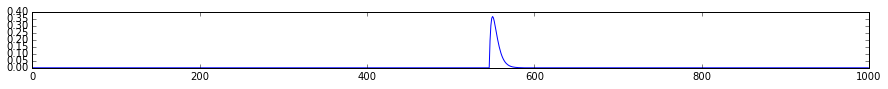

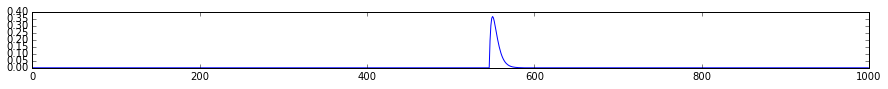

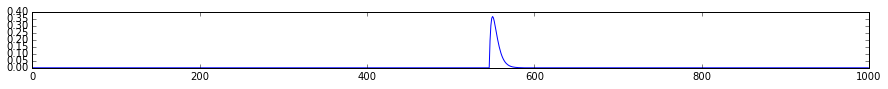

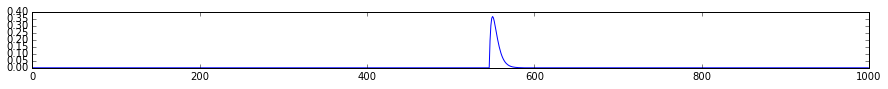

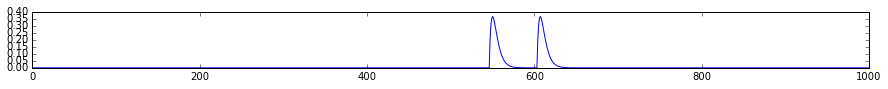

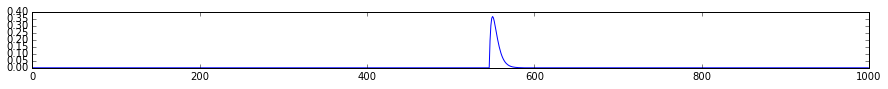

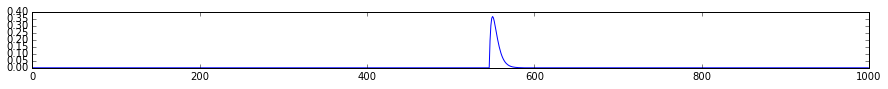

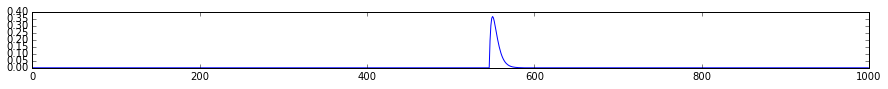

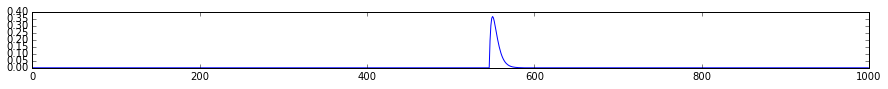

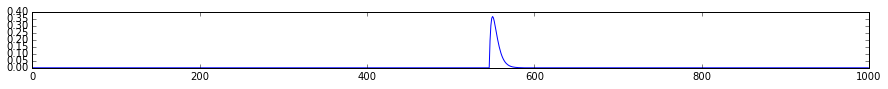

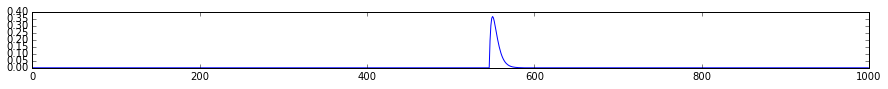

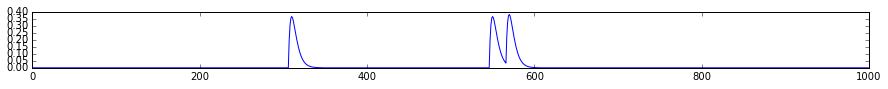

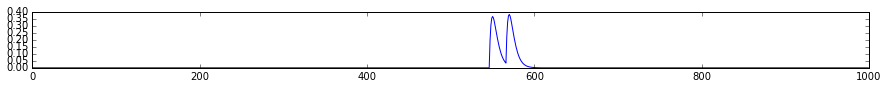

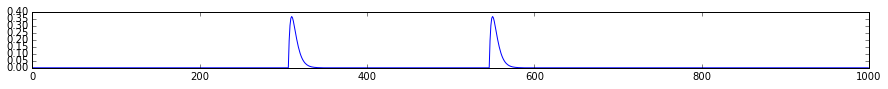

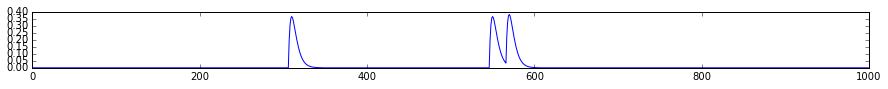

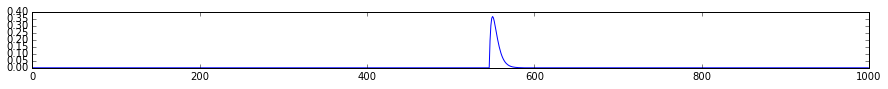

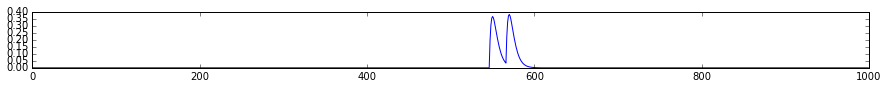

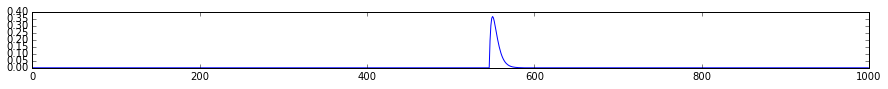

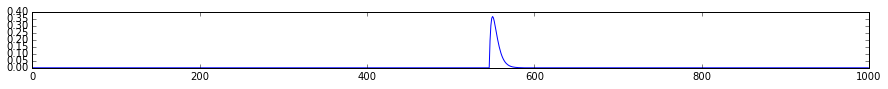

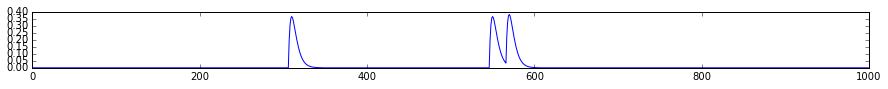

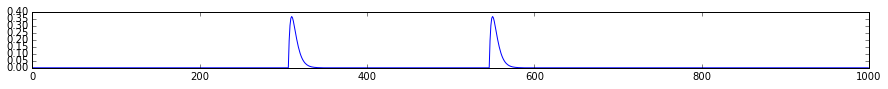

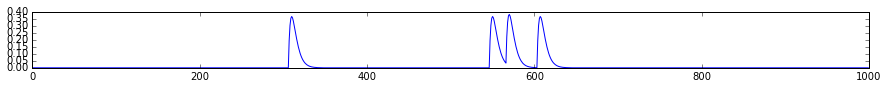

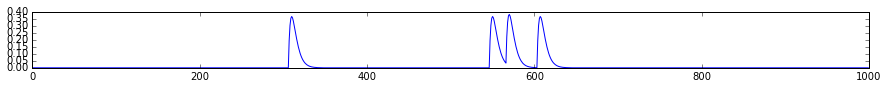

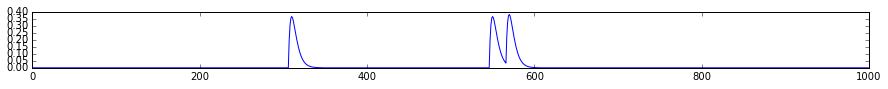

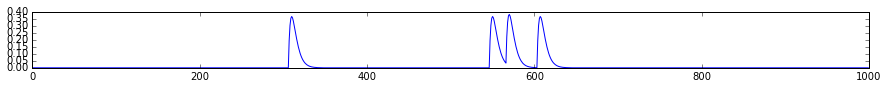

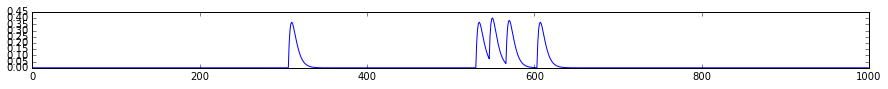

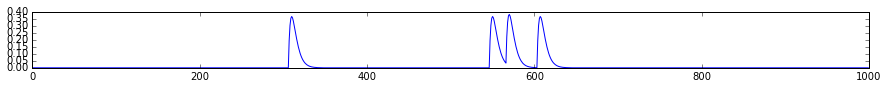

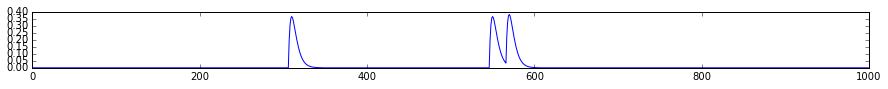

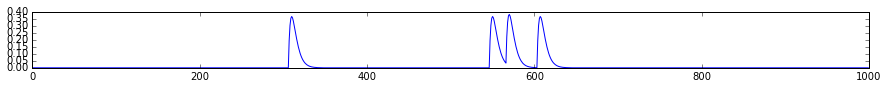

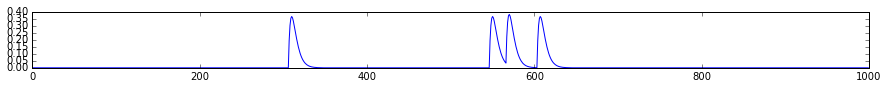

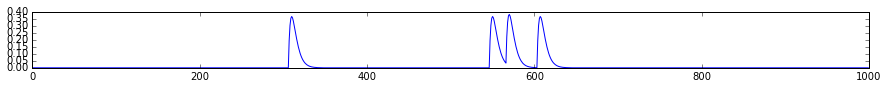

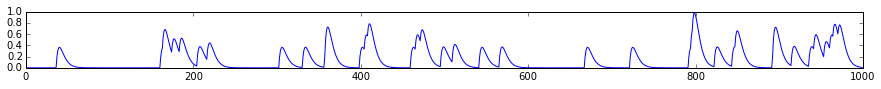

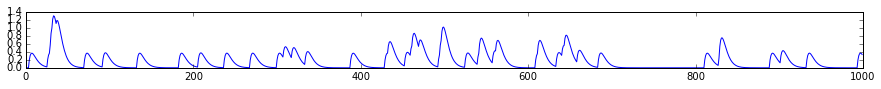

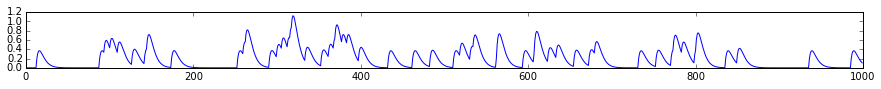

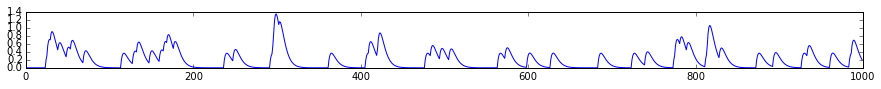

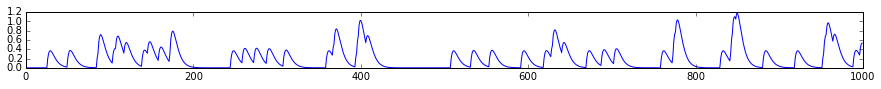

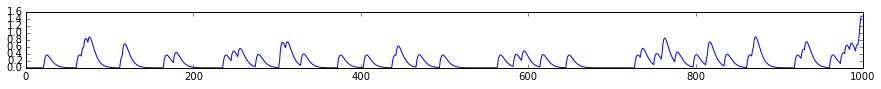

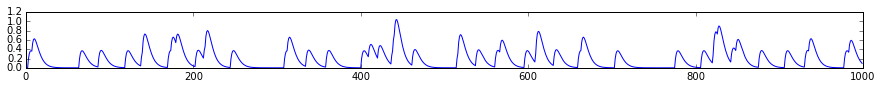

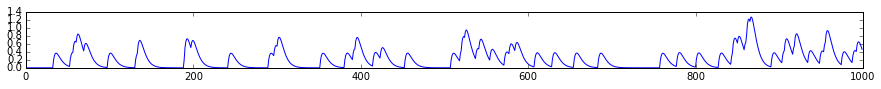

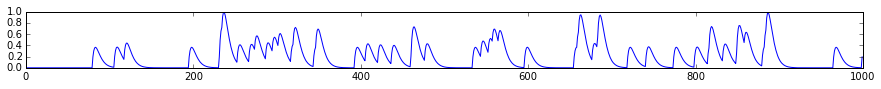

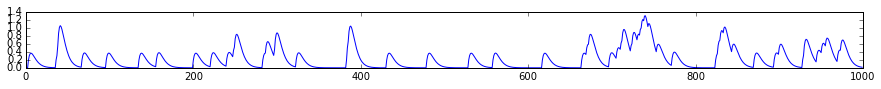

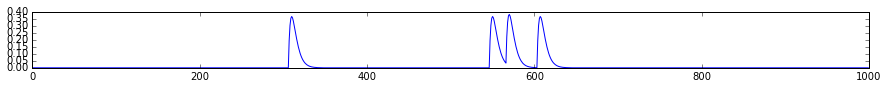

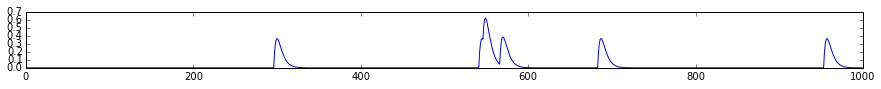

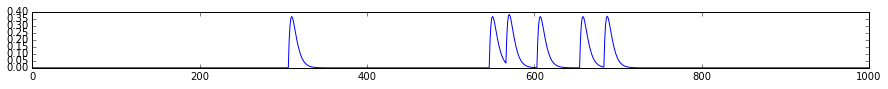

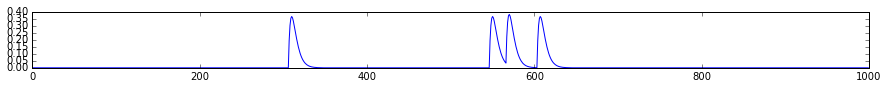

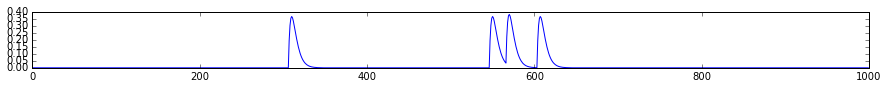

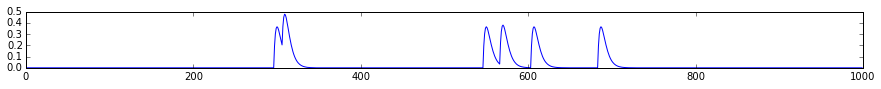

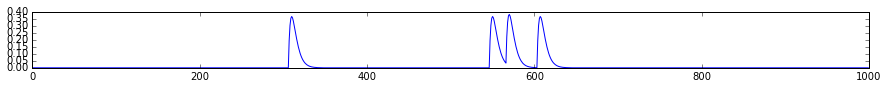

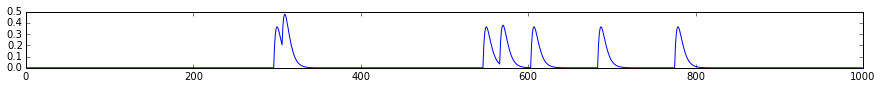

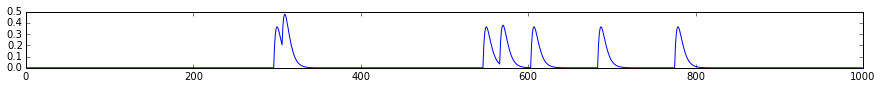

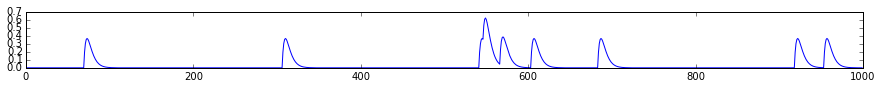

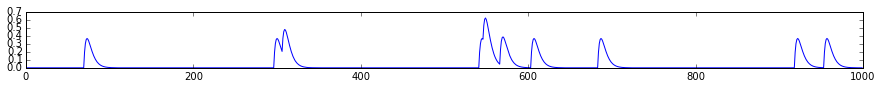

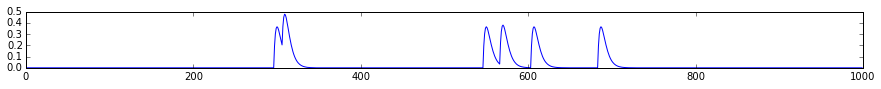

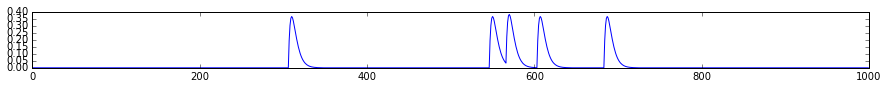

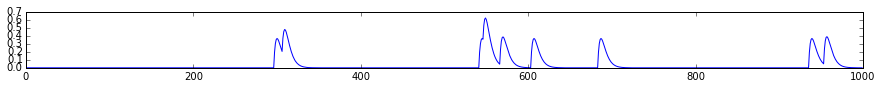

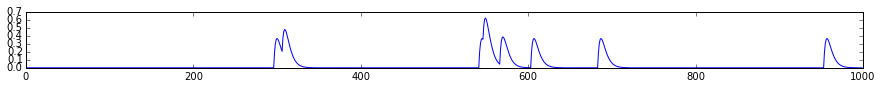

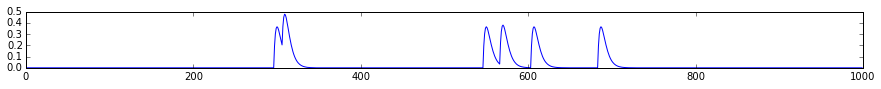

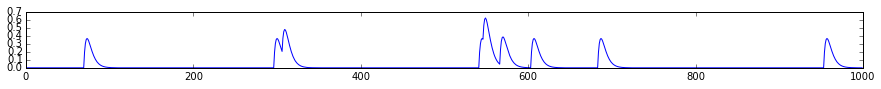

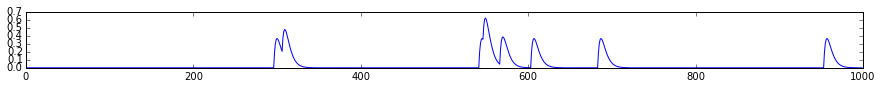

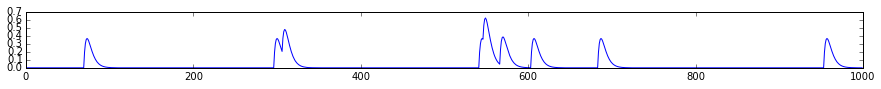

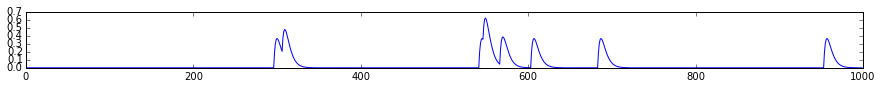

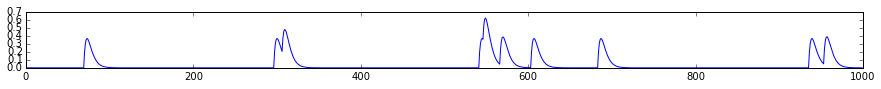

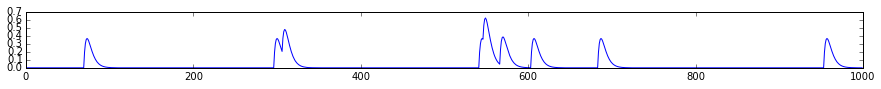

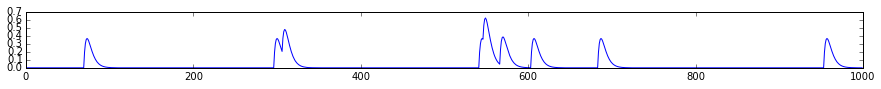

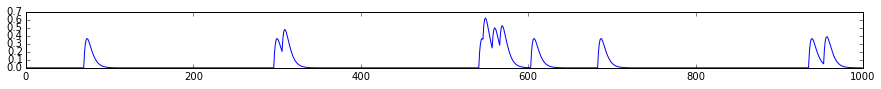

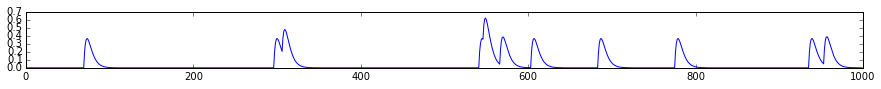

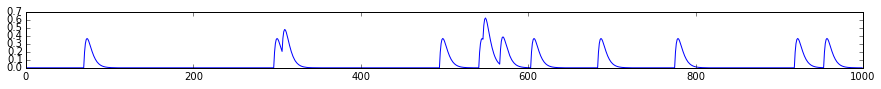

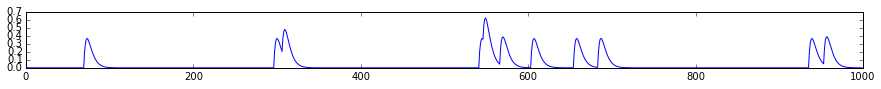

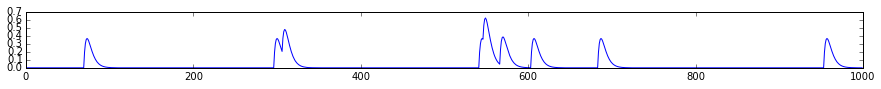

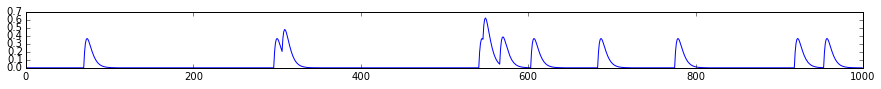

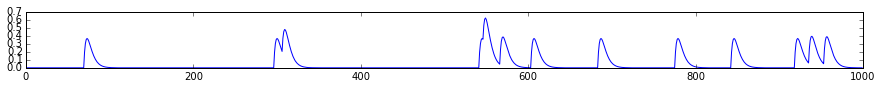

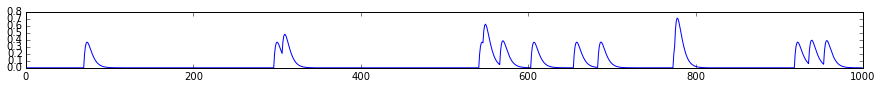

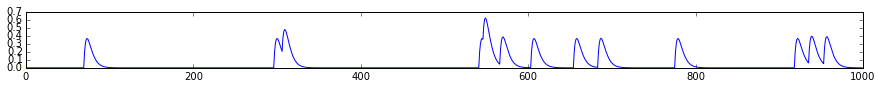

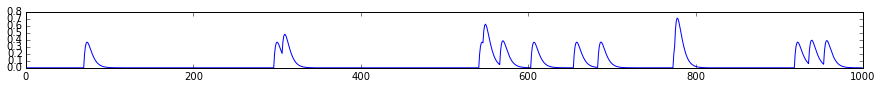

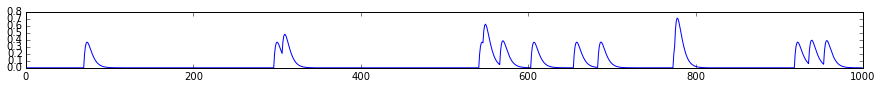

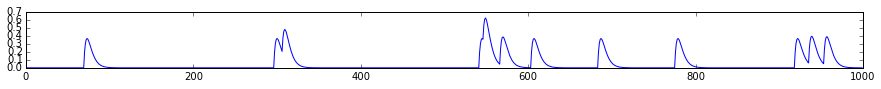

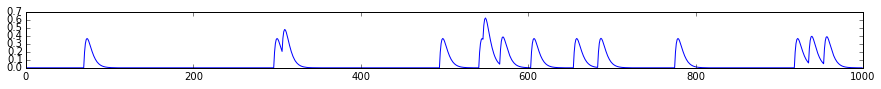

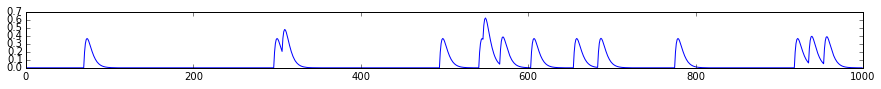

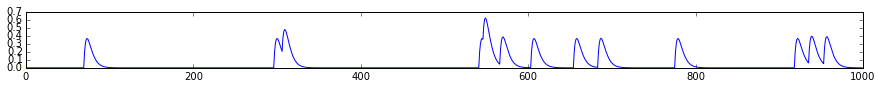

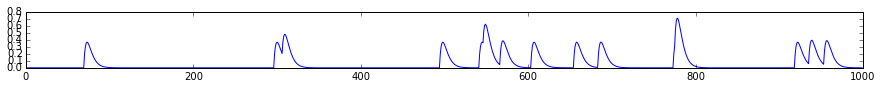

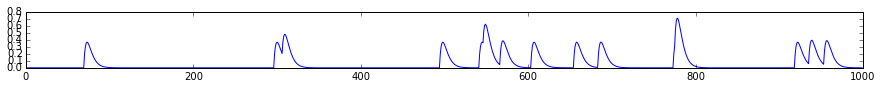

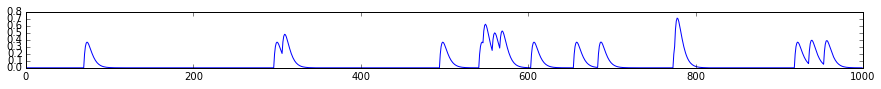

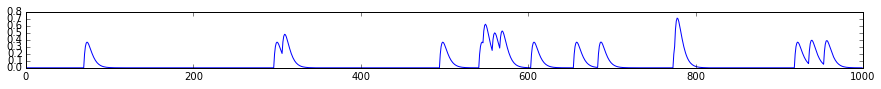

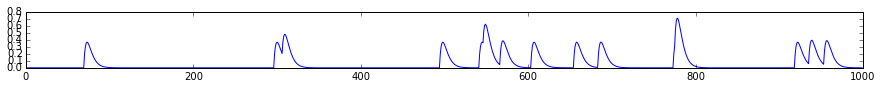

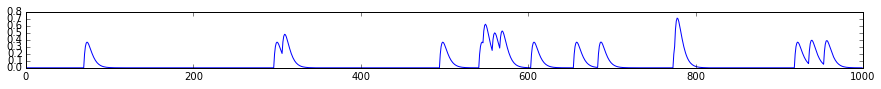

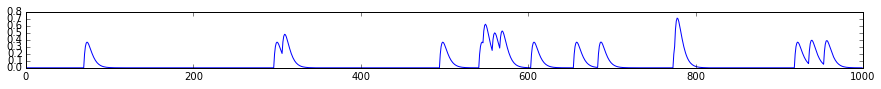

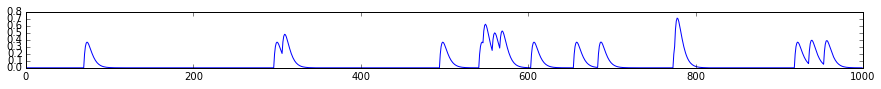

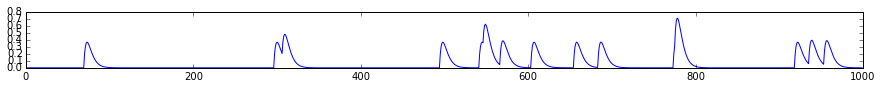

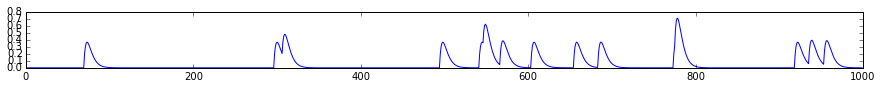

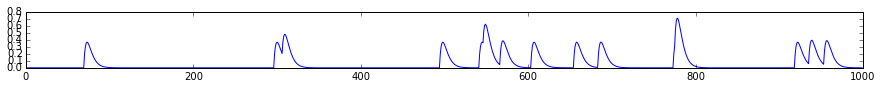

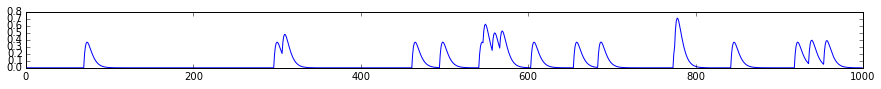

In [127]:
import random

class Neuron():
    def __init__(self, time):
        self.active = False #neuron is inactive
        self.activation = dict.fromkeys(range(time), 0) #neuron produces no action potentials
        self.input_neurons = [] #no neurons are connected
        self.clamped = False
        self.random = False
        self.threshold = 5
        
    def run(self, time):
        self.active = True
        self.activation = dict.fromkeys(range(time), 0)
        spiketrain = self.__calculateactivation(time)
        self.active = False
        return spiketrain
        
    def connect(self, neuron):
        self.input_neurons.append(neuron)
    
    def __calculateactivation(self, time):
        spiketrain = []
        
        # If the neuron is clamped it's _always_ fireing 
        # TODO: think refactory perior 
        if self.clamped:
            for step in range(time):
                self.activation[step] = 1
        
        # Some random firing 
        # TODO: not realistic 
        elif self.random:
                for i in range(time):
                    number = random.randint(0,20)
                    if number == 1:
                        self.activation[i] = 1
                    else:
                        self.activation[i] = 0
        
        else:
            for step in range(time):
                sum_inputs = 0
                for neuron in self.input_neurons:
                    #print("Step ", step, "Value ", neuron.activation[step])
                    sum_inputs += neuron.activation[step] 
                    #print("Sum ", sum_inputs)
                if sum_inputs > self.threshold:
                    self.activation[step] = 1
                else:
                    self.activation[step] = 0   
        spiketrain = list(self.activation.values())
        return spiketrain

class NeuronGroup():
    def __init__(self, neurons=[]):
        self.neurons = neurons    
    
    def record(self, time):
        spiketrains = []
        data = []
        for neuron in self.neurons:
            # run neuron; Order matters!
            # get its spiketrain
            spiketrain = neuron.run(time)
            spiketrains.append(spiketrain)
            # calculate calcium trace
            datum = produceCalciumTraceAdditive(spiketrain, template)
            data.append(datum)
            # display all traces
            plt.figure(figsize=(15, 1))
            plt.plot(datum)
            plt.show()
    
    # Becomes depricate with introduction of 
    # randomlyConnect as that can just be set to 100%
    def fullyConnect(self):
        for neuron1 in self.neurons:
            for neuron2 in self.neurons:
                neuron1.connect(neuron2)
                
    def randomlyConnect(self, percent):
        for neuron1 in self.neurons:
            for neuron2 in self.neurons:
                number = random.randint(0, 100)
                if number < percent:
                    neuron1.connect(neuron2)
        
    def initByNumber(self, number, time, random=False):
        for i in range(number):
            newNeuron = Neuron(time) 
            newNeuron.random = random
            self.neurons.append(newNeuron)
            
group1 = NeuronGroup()
group1.initByNumber(10, 1000, random=True)

group2 = NeuronGroup()
group2.initByNumber(50, 1000, random=False)

group3 = NeuronGroup(group1.neurons + group2.neurons)
#group3.fullyConnect()
group3.randomlyConnect(20)
group3.record(1000)